# Generalize pseudotime with LightGBM

## Set Environment

In [1]:
import lightgbm
import scanpy as sc
import pandas as pd
import numpy as np
import time as tm
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

/home/zhanglab/micromamba/envs/py311/lib/python3.11/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
%config InlineBackend.figure_format = 'retina'  # For high-resolution displays
%config InlineBackend.print_figure_kwargs = {'dpi': 200}  # Set DPI

In [3]:
sc.settings._vector_friendly=True

In [4]:
sc.settings.figdir = "../../results/trajectory/20241123_pseudotime/"

In [5]:
adata_full = sc.read("../../processed_data/integrated_data/20241118_mes.h5ad")

In [6]:
adata_full.obs["Project"]= adata_full.obs["Project"].astype("category")
sc.pp.highly_variable_genes(adata_full,n_top_genes=2000,flavor="cell_ranger",batch_key="Project")

In [7]:
varGene2 = adata_full.var_names[adata_full.var["highly_variable"]]

In [155]:
overlap = set(varGene2).intersection(set(varGene))

In [8]:
varGene2

Index(['Sgk3', 'Cpa6', 'Prex2', 'Sulf1', 'Eya1', 'Kcnb2', 'Sbspon', 'Rdh10',
       'Pi15', 'Crispld1',
       ...
       'Cartpt', 'Dleu2', '1700120C14Rik', 'Mir99ahg', 'Adgrf4',
       'C430049B03Rik', 'Pmch', '1810011O10Rik', '2810417H13Rik', 'Lect1'],
      dtype='object', length=2000)

In [156]:
len(overlap)

280

In [5]:
adata = sc.read("../../processed_data/integrated_data/20241118_mes.h5ad")

In [26]:
pseudotime = pd.read_csv("../../processed_data/trajectory/20241124_pseudotime_rerun.csv",index_col=0)

In [27]:
adata.obs["pseudotime"] = pseudotime.iloc[:,0]

In [ ]:
adata.obs["pseudotime"]

In [46]:
filterLogic = ~ adata.obs["pseudotime"].isna()

In [47]:
filterLogic

ToothNc_Junjun_AAACCCAAGCTAAGTA-1_1      True
ToothNc_Junjun_AAACCCACATCTATCT-1_1      True
ToothNc_Junjun_AAACCCAGTAGAATGT-1_1      True
ToothNc_Junjun_AAACCCAGTTCTCTCG-1_1      True
ToothNc_Junjun_AAACCCATCACAAGGG-1_1      True
                                        ...  
MolarP12_Tomoko_TTGGTTTAGTAATACG-1_1    False
MolarP12_Tomoko_TTGTGTTCACGTGTGC-1_1    False
MolarP12_Tomoko_TTGTTTGTCTTTGGAG-1_1    False
MolarP12_Tomoko_TTTGACTAGTGGTGGT-1_1    False
MolarP12_Tomoko_TTTGTTGTCCCACAGG-1_1    False
Name: pseudotime, Length: 152988, dtype: bool

In [49]:
adata = adata[filterLogic]

In [55]:
adata.var["highly_variable"]=False

In [134]:
adata.obs["batch"] = adata.obs["batch"].astype("category")

In [137]:
adata.obs["Project"]= adata.obs["Project"].astype("category")

In [139]:
sc.pp.highly_variable_genes(adata,n_top_genes=2000,flavor="cell_ranger",batch_key="Project")

In [150]:
adata.var

gene_symbols   n_cells  n_cells_by_counts  mean_counts  \
3110035E14Rik  3110035E14Rik      23.0               23.0     0.000062   
Sulf1                  Sulf1   95133.0            95133.0     0.783572   
Rdh10                  Rdh10  100218.0           100218.0     1.087321   
Tfap2b                Tfap2b   52672.0            52672.0     0.588765   
Pantr1                Pantr1   23763.0            23763.0     0.150208   
...                      ...       ...                ...          ...   
Apobec3-1          Apobec3-1     180.0              180.0     0.001262   
Cbx7-1                Cbx7-1     174.0              174.0     0.001684   
TrnV                    TrnV      12.0               12.0     0.000065   
C730027H18Rik  C730027H18Rik      12.0               12.0     0.000041   
Gm46204              Gm46204      10.0               10.0     0.000036   

               log1p_mean_counts  pct_dropout_by_counts   total_counts  \
3110035E14Rik           0.000062              99.993808      22.996221   
Sulf1                   0.578618              74.389919  291071.212365   
Rdh10                   0.735882              73.021022  403903.927843   
Tfap2b                  0.462957              85.820544  218706.737038   
Pantr1                  0.139942              93.602931   55797.137986   
...                          ...                    ...            ...   
Apobec3-1               0.001261              99.951543     468.766235   
Cbx7-1                  0.001682              99.953159     625.407564   
TrnV                    0.000065              99.996770      24.204535   
C730027H18Rik           0.000041              99.996770      15.085467   
Gm46204                 0.000036              99.997308      13.499798   

               log1p_total_counts  highly_variable     means  dispersions  \
3110035E14Rik            3.177896             True  0.000004     0.067898   
Sulf1                   12.581327             True  0.262959     0.984368   
Rdh10                   12.908935             True  0.344781     0.965146   
Tfap2b                  12.295492             True  0.238472     0.831608   
Pantr1                  10.929496             True  0.050902     0.562100   
...                           ...              ...       ...          ...   
Apobec3-1                6.152235             True  0.000578     0.044765   
Cbx7-1                   6.440001             True  0.000283     0.044110   
TrnV                     3.227024             True  0.000214     0.033345   
C730027H18Rik            2.777916             True  0.000003     0.025641   
Gm46204                  2.674135             True  0.000001     0.024039   

               dispersions_norm  highly_variable_nbatches  \
3110035E14Rik          0.053033                         1   
Sulf1                 -0.533172                        15   
Rdh10                 -0.202310                        15   
Tfap2b                 0.005445                        13   
Pantr1                -0.048822                         8   
...                         ...                       ...   
Apobec3-1             -0.911082                         1   
Cbx7-1                 0.000000                         1   
TrnV                   0.035064                         1   
C730027H18Rik         -0.017890                         1   
Gm46204                0.034440                         1   

               highly_variable_intersection  
3110035E14Rik                         False  
Sulf1                                  True  
Rdh10                                  True  
Tfap2b                                False  
Pantr1                                False  
...                                     ...  
Apobec3-1                             False  
Cbx7-1                                False  
TrnV                                  False  
C730027H18Rik                         False  
Gm46204                               False  

[2000 rows x 14 columns]

In [140]:
varGene2 = adata.var_names[adata.var["highly_variable"]]

In [9]:
pd.DataFrame(varGene2).to_csv("../../processed_data/framework/geneMeta/20241130_mes_vargene2_2000.csv")

In [144]:
overlap = set(varGene2).intersection(set(varGene))

In [148]:
varGene2[0:10]

Index(['3110035E14Rik', 'Sulf1', 'Rdh10', 'Tfap2b', 'Pantr1', 'Igfbp5', 'Wnt6',
       'Wnt10a', 'Pax3', 'Ecel1'],
      dtype='object')

In [149]:
varGene[0:10]

Index(['3110035E14Rik', 'Sulf1', 'Rdh10', 'Tfap2b', 'Pantr1', 'Igfbp5', 'Wnt6',
       'Wnt10a', 'Pax3', 'Ecel1'],
      dtype='object')

In [60]:
varGene = adata.var_names[adata.var["highly_variable"]]

In [128]:
varDf = pd.DataFrame(varGene)

In [130]:
varDf.to_csv("../../processed_data/framework/geneMeta/20241125_mes_vargene_2000.csv")

In [63]:
adata = adata[:,varGene]

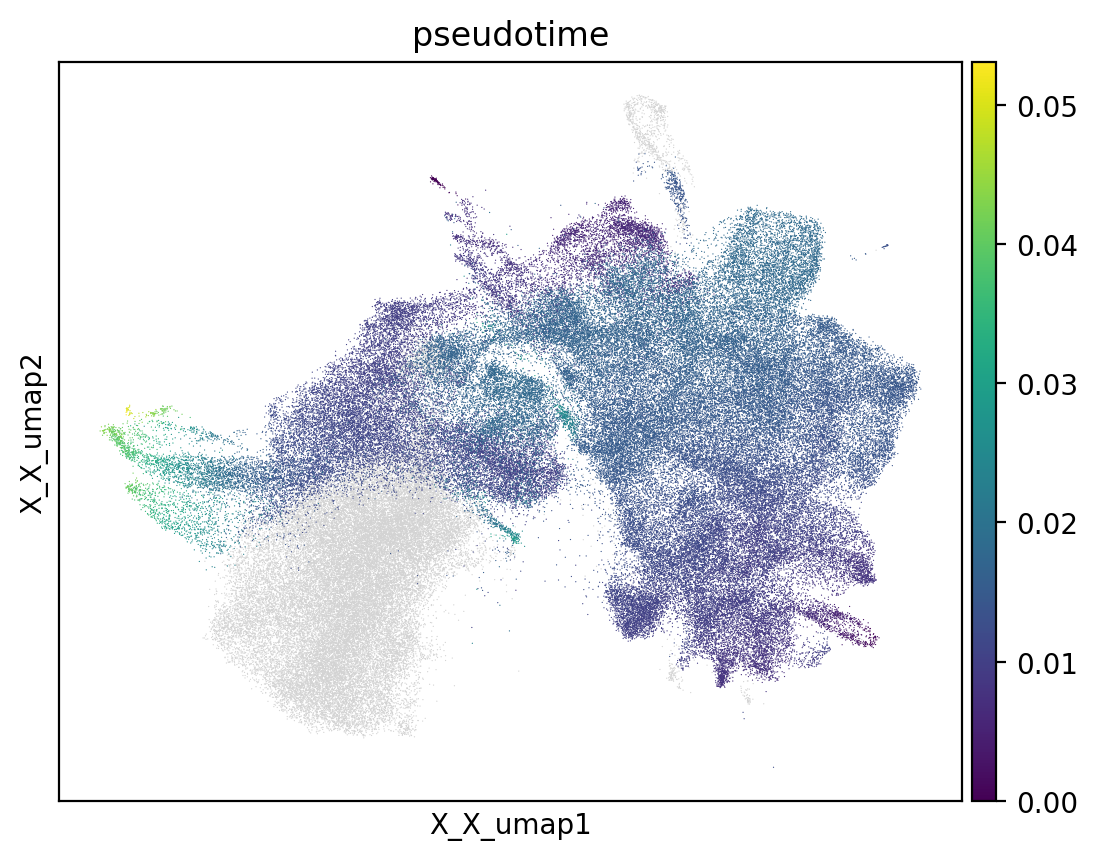

In [29]:
sc.pl.embedding(adata,color="pseudotime",basis="X_X_umap")

## Generalize

To establish a standardized measure of differentiation across both embryonic and postnatal stages, we developed a machine learning approach to learn differentiation states from gene expression data. Our strategy followed a three-step procedure: first, we analyzed global topology; second, we inferred pseudotime separately for embryonic and postnatal samples; and third, we employed machine learning on gene expression data to generate a generalized pseudotime metric. This generalized pseudotime, learned directly from expression patterns, serves as a universal indicator of differentiation status.
Based on our previous work in [TrajAtlas](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1011319), we selected LGBMRegressor for this analysis due to its demonstrated superior performance in both generalization capability and prediction accuracy

In [21]:
model=lightgbm.LGBMRegressor(n_jobs=-1)

In [31]:
def minmax_normalise(arr):
        
    norm_arr = []
    arr = np.asarray(arr)
    arr_max = max(arr)
    arr_min = min(arr)
    for i in range(len(arr)):
        norm_arr.append((arr[i] - arr_min )/(arr_max  - arr_min )) 
    return norm_arr

In [64]:
label=minmax_normalise(adata.obs["pseudotime"])
dataDf=adata.X.toarray()

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
     dataDf, label, test_size=0.4, random_state=0)

In [68]:
start=tm.time()
model.fit(X_train, y_train)
tr_time=tm.time()-start
start=tm.time()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.323397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126801
[LightGBM] [Info] Number of data points in the train set: 66388, number of used features: 524
[LightGBM] [Info] Start training from score 0.253634


In [74]:

ypred = model.predict(X_test)
ts_time=tm.time()-start
def adjusted_rsquared(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))
ypred = model.predict(X_test)
ts_time=tm.time()-start
r2 = sklearn.metrics.r2_score(y_test, ypred)
mse = mean_squared_error(y_test, ypred)
mae=mean_absolute_error(y_test, ypred)
rmse = np.sqrt(mean_squared_error(y_test, ypred))
adj_rsquared = adjusted_rsquared(
        r2, X_test.shape[0], X_test.shape[1]
)

In [80]:
y_test = np.array(y_test)

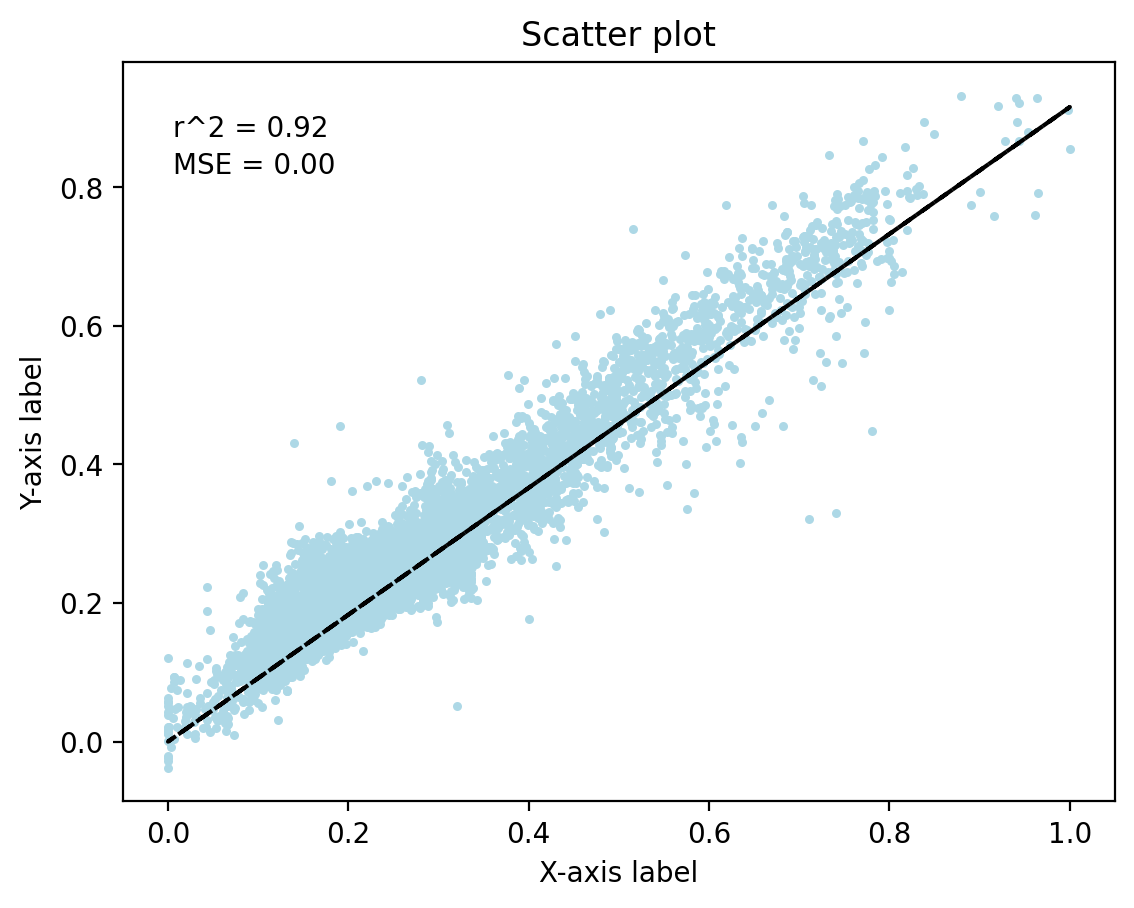

In [81]:
plt.scatter(y_test, ypred,s=5, marker='o',color='lightblue',rasterized=True)
plt.plot(y_test, y_test*r2, color='black', linestyle='--', label='Regression Line')

plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Scatter plot')

plt.annotate('r^2 = {:.2f}'.format(r2), xy=(0.05, 0.90), xycoords='axes fraction')
plt.annotate('MSE = {:.2f}'.format(mse), xy=(0.05, 0.85), xycoords='axes fraction')
plt.savefig("../../results/trajectory/20241123_pseudotime/20241124_pseudo_pred.pdf")
# Display the plot
plt.show()

The LightGBM model demonstrated excellent prediction accuracy in our analysis.

In [82]:
lightDpt=model.predict(dataDf)

In [83]:
adata.obs["lightGBM"]=lightDpt

/tmp/ipykernel_1241262/1238163458.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["lightGBM"]=lightDpt


In [86]:
adata

AnnData object with n_obs × n_vars = 110648 × 2000
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'nCount_RNA', 'nFeature_RNA', 'coarse_anno_1', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'size_factors', 'Sample', 'Project', 'Core_datasets', 'Mandibular_Maxillary', 'Molar_Incisor', 'Tooth.position', 'Histology', 'Sex', 'Gene.Type', 'Knockout_gene', 'Cre', 'Treatment', 'FACs', 'Age', 'Stage', 'Development.stage', 'Disease', 'Strain', 'Dissociation_enzyme', 'Machine', 'Species', 'Related.assay', 'Journal', 'Data.Source', 'Data.location', 'new_totals_log', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'scDblFinder_class', 'leiden', 'anno_level_1', 'Cell_ID', 'leiden_clusters_level_1', 'leiden_clusters_level_2', 'leiden_clusters_level_3', 'leiden_clusters_level_4', 'leiden_c

## Visualization

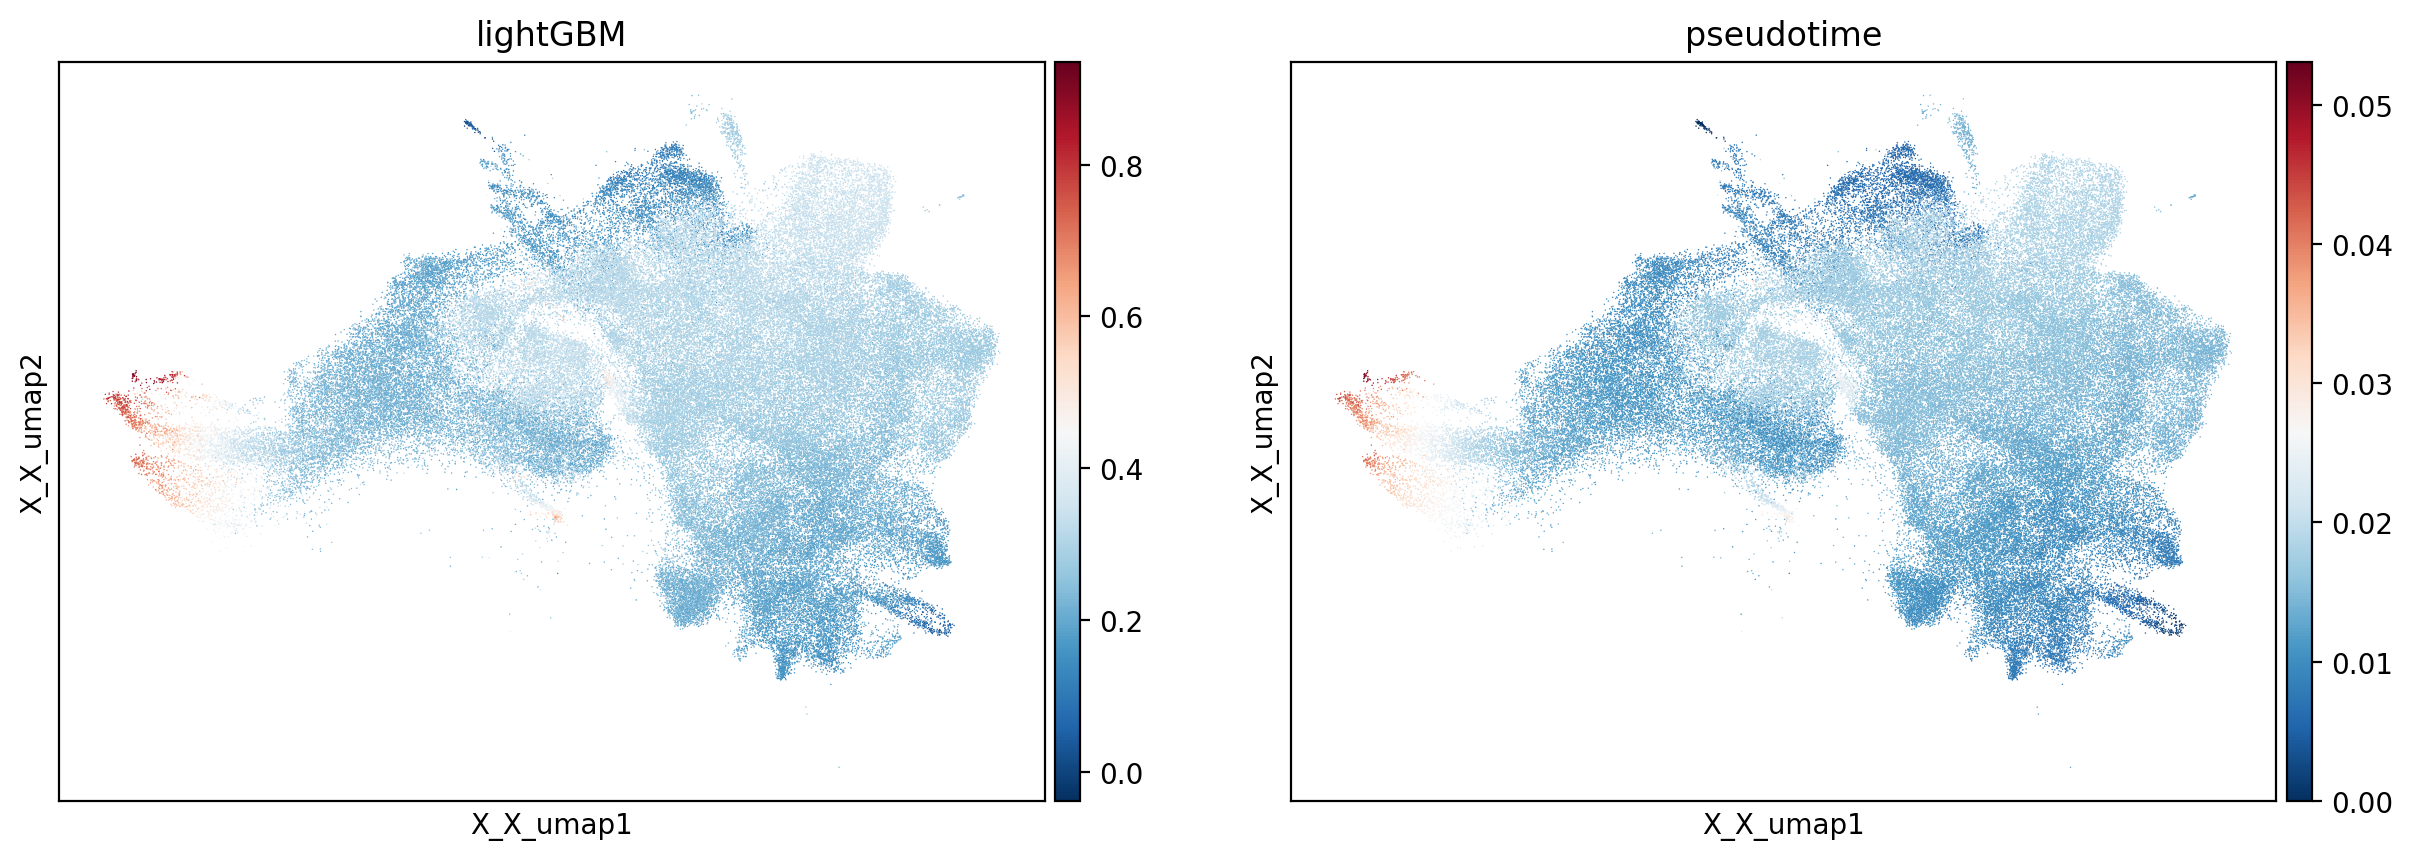

In [88]:
sc.pl.embedding(adata,color=["lightGBM","pseudotime"],basis="X_X_umap",cmap="RdBu_r",save="_lightGBM_pred")

In [90]:
emb1 = pd.read_csv("../../processed_data/framework/embedding/20241119_mes_drawgraph.csv",index_col=0)

In [95]:
emb1 = emb1.loc[adata.obs_names]

In [96]:
adata.obsm["X_draw_graph"] = np.array(emb1)

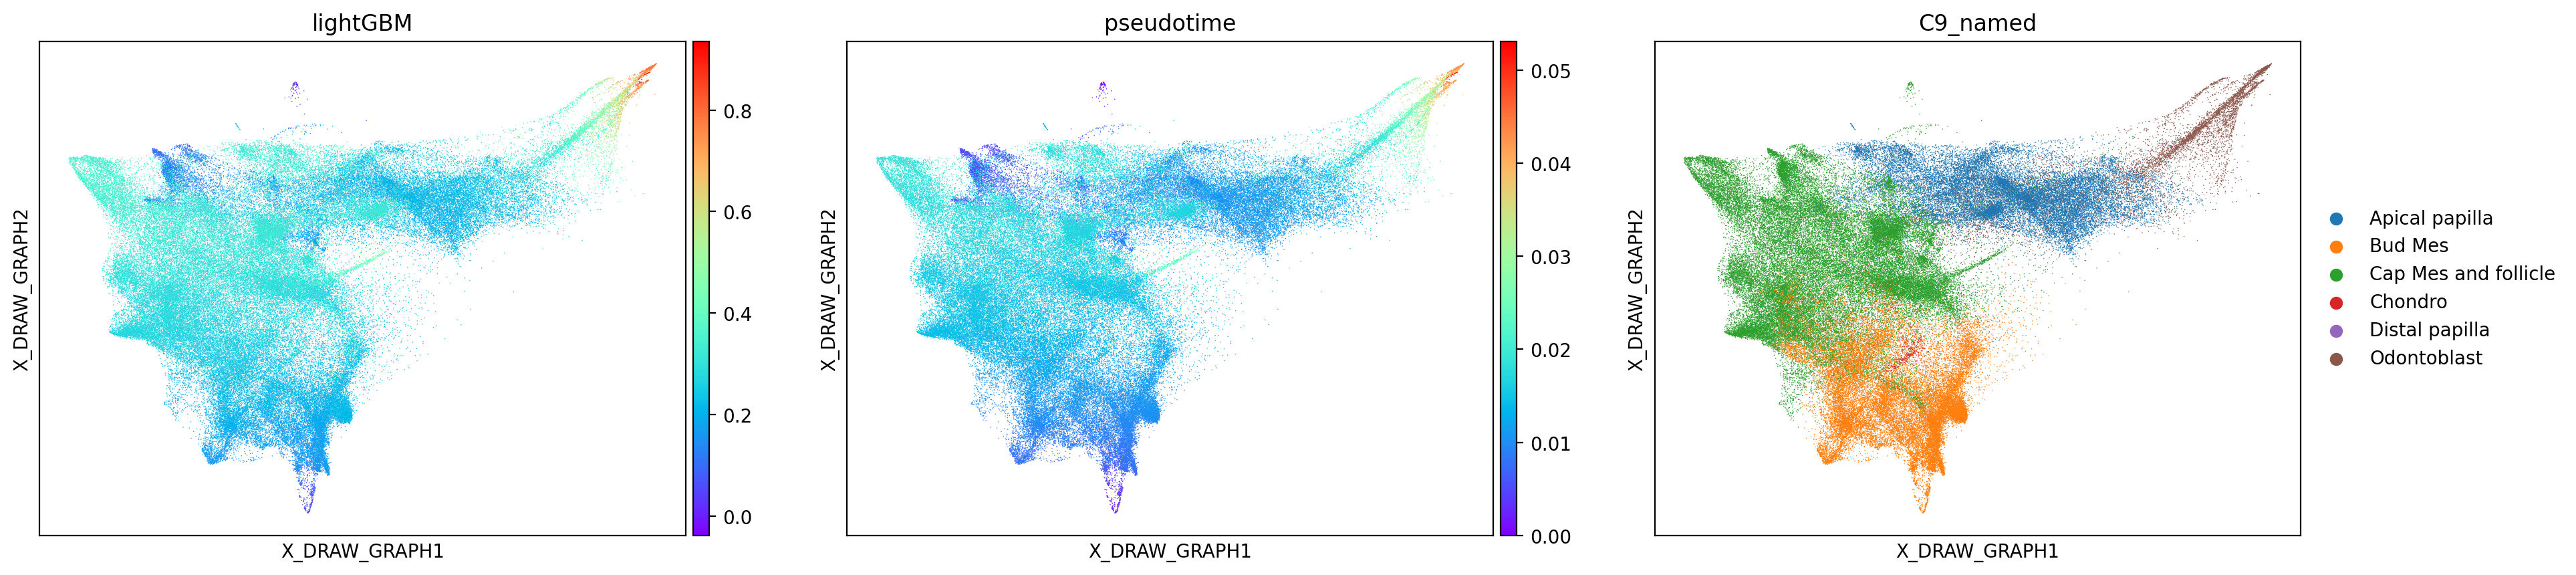

In [103]:
sc.pl.embedding(adata,color=["lightGBM","pseudotime","C9_named"],cmap="rainbow",basis="X_draw_graph",save="_lightGBM_pred_drawgraph")

In [104]:
diffmap = pd.read_csv("../../processed_data/framework/embedding/20241119_mes_diffmap_10.csv",index_col=0)

In [105]:
diffmap = diffmap.loc[adata.obs_names]

In [115]:
adata.obsm["X_diffmap"] = np.array(diffmap.iloc[:,[1,3]])

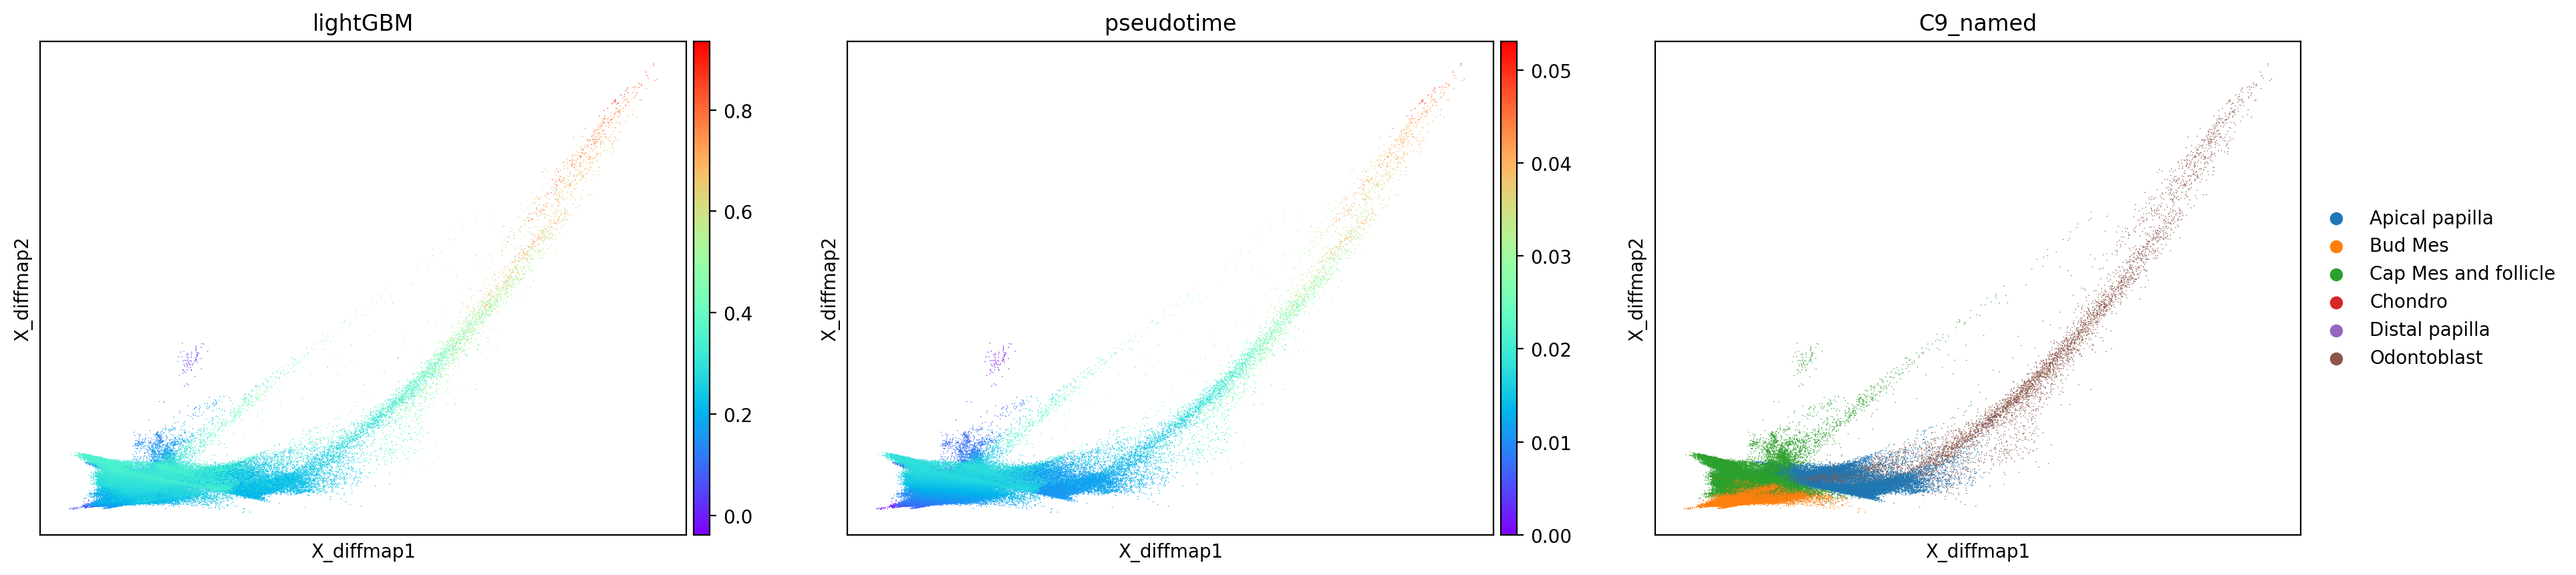

In [116]:
sc.pl.embedding(adata,color=["lightGBM","pseudotime","C9_named"],cmap="rainbow",basis="X_diffmap",save="_lightGBM_pred_drawgraph")

The diffusion map revealed a clear developmental continuum, characterized by gradual changes in pseudotime values.

## Save Result

In [126]:
pd.DataFrame(adata.obs[["lightGBM","pseudotime"]]).to_csv("../../processed_data/trajectory/20241124_pseudotime_predicted.csv")